Part I: Simple Game Implementation (Key and Door)
---

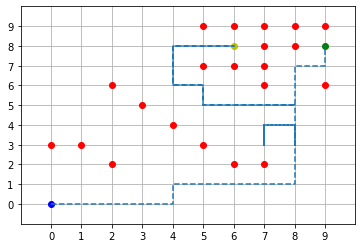

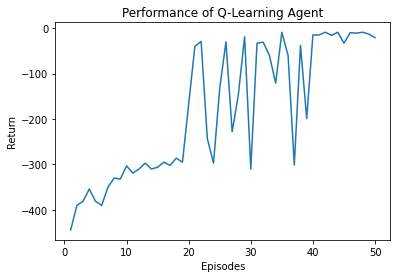

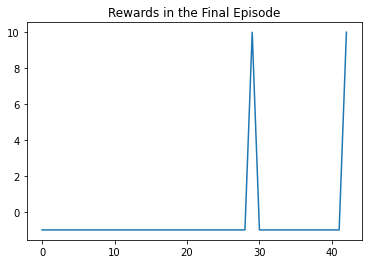

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
#---------------------------------------
def Game_Environment(S,A,Xmax,Ymax,S_Key,S_Terminal,S_Unsafe,S_Initial):
  # A => {0,1,2,3} for {Up,Down,Left,Right}
  S_next = np.array([0,0,0],dtype=int)
  S_next[0] = int(np.clip(S[0] + 1*((A == 3)+0) - 1*((A == 2)+0),a_min=0,a_max=Xmax-1))
  S_next[1] = int(np.clip(S[1] + 1*((A == 0)+0) - 1*((A == 1)+0),a_min=0,a_max=Ymax-1))
  S_next[2] = S[2]
  R = -1
  if np.array_equal(S_next,S_Key):
    S_next[2] = 1
    R = 10
  if np.array_equal(S_next,S_Terminal):
    R = 10
  for k in range(np.shape(S_Unsafe)[0]):
    if np.array_equal(np.reshape(S_next[0:2],(1,2)),S_Unsafe[k,:][0]):
      R = -10
      S_next = S_Initial
      break

  return S_next,R;
#---------------------------------------
S_Initial = np.array([0,0,0],dtype=int)
S_Terminal = np.array([9,8,1],dtype=int)
S_Key = np.array([6,8,0])
S_Unsafe = np.matrix([[7,6],[7,7],[7,8],[7,9],[8,8],[8,9],[9,9],[7,2],[6,2],[5,3],[4,4],[3,5],[2,6],[9,6],[0,3],[1,3],[2,2]
                      ,[6,7],[5,7],[6,9],[5,9]])
Xm = 10
Ym = 10
#---------------------------------------
N_Episodes = 50
#---------------------------------------
alpha = 0.7
gamma = 1
eps = 0.1
#---------------------------------------
Return = np.zeros((1,N_Episodes))
R_List = []
S0 = []
S1 = []
Q = np.zeros((Xm,Ym,2,4))
#---------------------------------------
for episode in range(N_Episodes):
  if episode == 40:
    eps = 0
  # S_Initial = np.array([np.random.randint(Xm),np.random.randint(Ym),0]) # Random Initial State
  S = S_Initial
  i = 0
  while not(np.array_equal(S,S_Terminal)) and (i<300):
    i = i + 1
    # Action Selection
    greed = np.random.binomial(1,eps)
    if greed:
      A = np.random.randint(4)
    else:
      A = np.argmax(Q[S[0],S[1],S[2],:])
    # Interact
    S_next,R = Game_Environment(S,A,Xm,Ym,S_Key,S_Terminal,S_Unsafe,S_Initial)
    # Update
    Q[S[0],S[1],S[2],A] = Q[S[0],S[1],S[2],A] + alpha*(R + gamma*np.max(Q[S_next[0],S_next[1],S_next[2],:]) - Q[S[0],S[1],S[2],A])
    # Replace and Store
    if episode == (N_Episodes-1):
      # clear_output()
      S0.append(S[0])
      S1.append(S[1])
      if np.array_equal(S_next,S_Terminal):
        S0.append(S_next[0])
        S1.append(S_next[1])
    S = S_next
    if episode == (N_Episodes-1):
      R_List.append(R)
    Return[0,episode] = Return[0,episode] + R
  # if episode >= 30:
  #   fig = plt.figure()
  #   plt.plot(S0,S1,'ro-')
  #   plt.xlim(-1,Xm)
  #   plt.ylim(-1,Ym)
  #   plt.show()
  #   sleep(0.01)
  # S0 = []
  # S1 = []

fig = plt.figure()
plt.plot(S_Key[0],S_Key[1],'yo',)
plt.plot(S_Initial[0],S_Initial[1],'bo',)
plt.plot(S_Terminal[0],S_Terminal[1],'go')
plt.plot(S_Unsafe[:,0],S_Unsafe[:,1],'ro')
plt.plot(S0,S1,'--')
plt.xlim(-1,Xm)
plt.ylim(-1,Ym)
plt.grid('minor')
plt.yticks(np.arange(0, 10, 1))
plt.xticks(np.arange(0, 10, 1))
plt.show()

E = np.reshape(np.arange(1,N_Episodes+1),(1,N_Episodes))
plt.plot(E.T,Return.T)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Performance of Q-Learning Agent')
plt.show()
plt.plot(R_List)
plt.title('Rewards in the Final Episode')
plt.show()

Part II: Applying Different Safety Margins
---

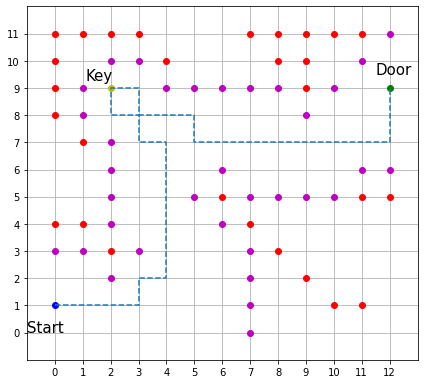

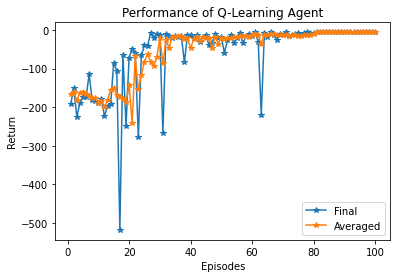

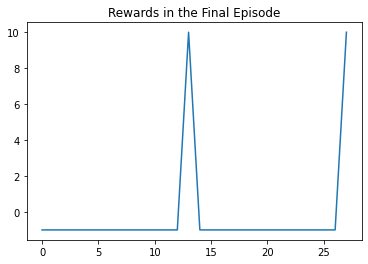

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import sleep
#---------------------------------------
def Game_Environment(S,A,Xmax,Ymax,S_Key,S_Terminal,S_Unsafe,S_Initial,MarginMode,Triggers,Kappa_i,Tau_i):
  # A => {0,1,2,3} for {Up,Down,Left,Right}
  global Tau_i_count
  global Kappa_i_count
  Failed = 0
  S_next = np.array([0,0,0],dtype=int)
  S_next[0] = int(np.clip(S[0] + 1*((A == 3)+0) - 1*((A == 2)+0),a_min=0,a_max=Xmax-1))
  S_next[1] = int(np.clip(S[1] + 1*((A == 0)+0) - 1*((A == 1)+0),a_min=0,a_max=Ymax-1))
  S_next[2] = S[2]
  R = -1
  if np.array_equal(S_next,S_Key):
    S_next[2] = 1
    R = 10
  if np.array_equal(S_next,S_Terminal):
    R = 10
  for k in range(np.shape(S_Unsafe)[0]):
    if np.array_equal(np.reshape(S_next[0:2],(1,2)),S_Unsafe[k,:][0]):
      S_next = S_Initial
      if Kappa_i_count < Kappa_i:
        R = -5 # Unsafe state penalty
        Kappa_i_count = Kappa_i_count + 1
      else:
        Failed = 1
        R = -10
      break
  # Interruption Modes
  if MarginMode != 0:
    for k in range(np.shape(Triggers)[0]):
      if np.array_equal(np.reshape(S_next[0:2],(1,2)),Triggers[k,:][0]):
        if Tau_i_count < Tau_i:
          R = -5 # Trigger state penalty
          Tau_i_count = Tau_i_count + 1
          if MarginMode == 1: # Hard Reset
            S_next = S_Initial
          else:
            S_next = S
          if S[2] == 1:
            R = R - 10 # Also, reset the reward of finding the key
        else:
          R = -1
        break
  return S_next,R,Failed
#---------------------------------------
Xm = 13
Ym = 12
S_Initial = np.array([0,1,0],dtype=int)
S_Terminal = np.array([12,9,1],dtype=int)
S_Key = np.array([2,9,0])
S_Unsafe = np.matrix([[0,4],[1,4],[2,3]
                      ,[11,1],[10,1],[9,2],[8,3],[7,4],[6,5]
                      ,[12,5],[11,5]
                      ,[11,11],[10,11],[9,9],[9,10],[9,11],[8,10],[8,11],[7,11]
                      ,[0,11],[1,11],[2,11],[3,11],[4,10],[0,10],[0,9],[0,8],[1,7]])

Triggers_SR1 = np.matrix([[0,3],[1,3],[2,2],[3,3],[2,4],[1,5]
                          ,[6,4],[7,3],[8,2],[9,1],[10,0],[7,5],[8,4],[9,3],[10,2],[12,1],[11,2],[5,5],[6,6]
                          ,[9,8],[8,9],[7,10],[6,11],[10,9],[11,10],[12,11]
                          ,[12,4],[12,6],[10,5],[11,4],[11,6]
                          ,[1,6],[2,7],[1,8],[1,9],[2,10],[3,10],[4,9],[5,10]])

Triggers_SR2 = np.matrix([[0,3],[1,3],[2,2],[3,3],[2,4],[2,5]
                          ,[6,4],[7,3],[7,2],[7,1],[7,0],[7,5],[8,5],[9,5],[5,5],[6,6]
                          ,[9,8],[8,9],[7,9],[6,9],[10,9],[11,10],[12,11]
                          ,[12,6],[10,5],[11,6]
                          ,[2,6],[2,7],[1,8],[1,9],[2,10],[3,10],[4,9],[5,9]])

#MarginMode = 3 # {0,1,2,3} for {Free Mode (with HR), Hard Reset and Set 1, Soft Reset 1, Soft Reset 2}

Kappa_i_original = 2
Tau_i_original = 6
#---------------------------------------
N_Episodes = 100
N_Replays = 10
#---------------------------------------
AveragedValues = np.zeros((4,100))
for MarginMode in range(4):
  R_List = []
  S0 = []
  S1 = []
  for replay in range(N_Replays):
    #---------------------------------------
    alpha = 0.7
    gamma = 1
    eps = 0.1
    #---------------------------------------
    Return = np.zeros((1,N_Episodes))
    Q = np.zeros((Xm,Ym,2,4))
    #---------------------------------------
    for episode in range(N_Episodes):
      np.random.seed(episode+replay)
      Tau_i_count = 0
      Kappa_i_count = 0
      if episode == int(0.8*N_Episodes):
        eps = 0
      # S_Initial = np.array([np.random.randint(Xm),np.random.randint(Ym),0]) # Random Initial State
      S = S_Initial
      i = 0
      Failed = 0
      while not(np.array_equal(S,S_Terminal)) and not(Failed):
        i = i + 1
        # Action Selection
        greed = np.random.binomial(1,eps)
        if greed:
          A = np.random.randint(4)
        else:
          A = np.argmax(Q[S[0],S[1],S[2],:])
        # Interact
        if MarginMode != 3:
          Triggers = Triggers_SR1
        else:
          Triggers = Triggers_SR2
        if MarginMode != 0:
          Tau_i = Tau_i_original
          Kappa_i = Kappa_i_original
        else:
          Tau_i = 0
          Kappa_i = Kappa_i_original + Tau_i_original
        S_next,R,Failed = Game_Environment(S,A,Xm,Ym,S_Key,S_Terminal,S_Unsafe,S_Initial,MarginMode,Triggers,Kappa_i,Tau_i)
        # Update
        Q[S[0],S[1],S[2],A] = Q[S[0],S[1],S[2],A] + alpha*(R + gamma*np.max(Q[S_next[0],S_next[1],S_next[2],:]) - Q[S[0],S[1],S[2],A])
        # Replace and Store
        if episode == (N_Episodes-1) and replay == (N_Replays-1):
          S0.append(S[0])
          S1.append(S[1])
          if np.array_equal(S_next,S_Terminal):
            S0.append(S_next[0])
            S1.append(S_next[1])
        S = S_next
        if episode == (N_Episodes-1) and replay == (N_Replays-1):
          R_List.append(R)
        Return[0,episode] = Return[0,episode] + R
      Return[0,episode] = Return[0,episode] + 4*Tau_i_count
    if replay == 0:
      AvgReturn = Return
    else:
      AvgReturn = (Return + replay*AvgReturn)/(replay+1)
  AveragedValues[MarginMode,:] = AvgReturn

fig = plt.figure(figsize=((Xm+1)/2,(Ym+1)/2))
plt.plot(S_Key[0],S_Key[1],'yo',)
plt.plot(S_Initial[0],S_Initial[1],'bo',)
plt.text(S_Initial[0]-1,S_Initial[1]-1,'Start',fontsize=15)
plt.text(S_Key[0]-0.9,S_Key[1]+0.3,'Key',fontsize=15)
plt.text(S_Terminal[0]-0.5,S_Terminal[1]+0.5,'Door',fontsize=15)

plt.plot(S_Terminal[0],S_Terminal[1],'go')
plt.plot(S_Unsafe[:,0],S_Unsafe[:,1],'ro')

# plt.plot(Triggers_SR1[:,0],Triggers_SR1[:,1],'ko')
# plt.plot(Triggers_SR2[:,0],Triggers_SR2[:,1],'mo')
if MarginMode != 0:
  plt.plot(Triggers[:,0],Triggers[:,1],'mo')

plt.plot(S0,S1,'--')
plt.xlim(-1,Xm)
plt.ylim(-1,Ym)
plt.grid('minor')
plt.xticks(np.arange(0, Xm, 1))
plt.yticks(np.arange(0, Ym, 1))
plt.show()

E = np.reshape(np.arange(1,N_Episodes+1),(1,N_Episodes))
plt.plot(E.T,Return.T,'*-')
plt.plot(E.T,AvgReturn.T,'*-')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Performance of Q-Learning Agent')
plt.legend(['Final','Averaged'])
plt.show()
plt.plot(R_List)
plt.title('Rewards in the Final Episode')
plt.show()


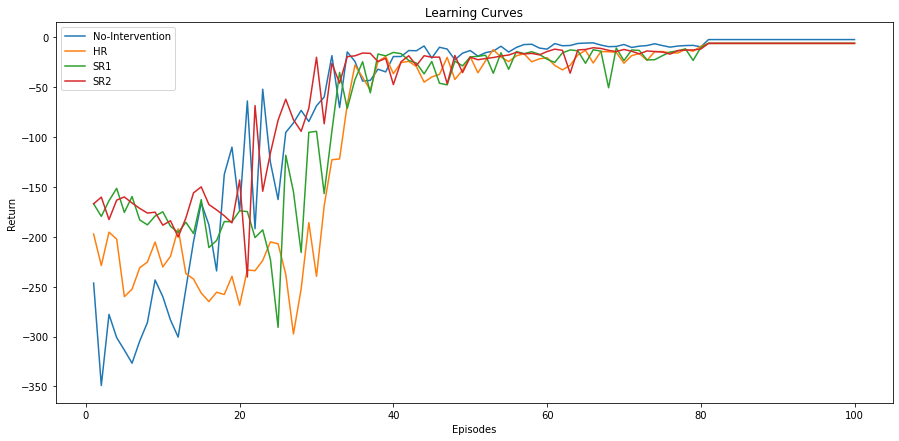

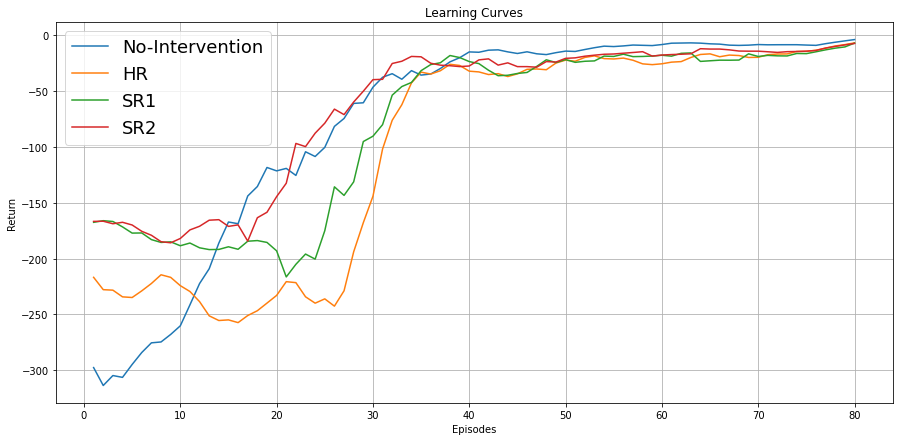

In [53]:
E = np.reshape(np.arange(1,N_Episodes+1),(1,N_Episodes))
fig = plt.figure(figsize=(15,7))
plt.plot(E.T,AveragedValues.T)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Learning Curves')
plt.legend(['No-Intervention','HR','SR1','SR2'])
plt.show()
V = np.copy(AveragedValues)
for i in range(4):
  V[i,:] = np.convolve(V[i,:],np.ones((1,5))[0]/5)[4::]

fig = plt.figure(figsize=(15,7))
plt.plot(E.T[0:80],V[:,0:80].T)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Learning Curves')
plt.legend(['No-Intervention','HR','SR1','SR2'],fontsize=18)
plt.grid('minor')
plt.show()

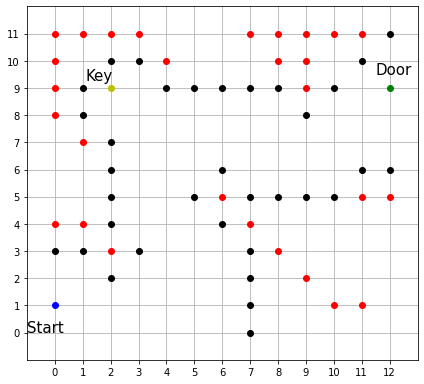

In [7]:
fig = plt.figure(figsize=((Xm+1)/2,(Ym+1)/2))
plt.plot(S_Key[0],S_Key[1],'yo',)
plt.plot(S_Initial[0],S_Initial[1],'bo',)
plt.text(S_Initial[0]-1,S_Initial[1]-1,'Start',fontsize=15)
plt.text(S_Key[0]-0.9,S_Key[1]+0.3,'Key',fontsize=15)
plt.text(S_Terminal[0]-0.5,S_Terminal[1]+0.5,'Door',fontsize=15)

plt.plot(S_Terminal[0],S_Terminal[1],'go')
plt.plot(S_Unsafe[:,0],S_Unsafe[:,1],'ro')

# plt.plot(Triggers_SR1[:,0],Triggers_SR1[:,1],'ko')
plt.plot(Triggers_SR2[:,0],Triggers_SR2[:,1],'ko')
plt.xlim(-1,Xm)
plt.ylim(-1,Ym)
plt.grid('minor')
plt.xticks(np.arange(0, Xm, 1))
plt.yticks(np.arange(0, Ym, 1))
plt.show()

Part III: Applying Different Safety Margins after specific numbers of episodes
---

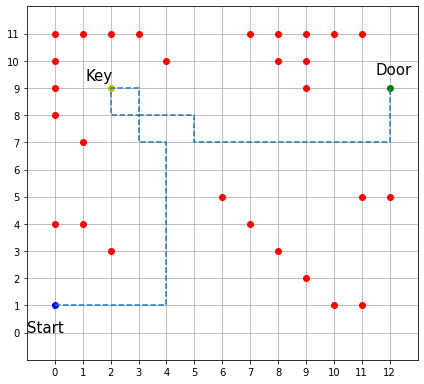

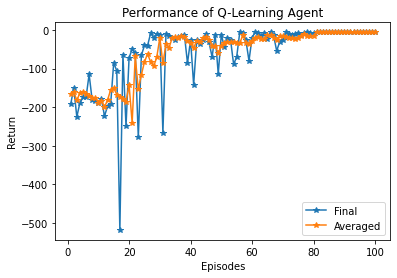

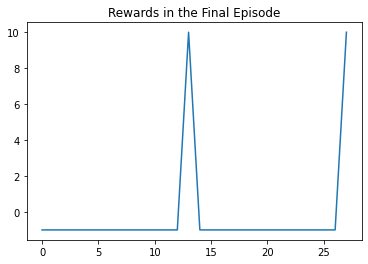

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
#---------------------------------------
def Game_Environment(S,A,Xmax,Ymax,S_Key,S_Terminal,S_Unsafe,S_Initial,MarginMode,Triggers,Kappa_i,Tau_i):
  # A => {0,1,2,3} for {Up,Down,Left,Right}
  global Tau_i_count
  global Kappa_i_count
  Failed = 0
  S_next = np.array([0,0,0],dtype=int)
  S_next[0] = int(np.clip(S[0] + 1*((A == 3)+0) - 1*((A == 2)+0),a_min=0,a_max=Xmax-1))
  S_next[1] = int(np.clip(S[1] + 1*((A == 0)+0) - 1*((A == 1)+0),a_min=0,a_max=Ymax-1))
  S_next[2] = S[2]
  R = -1
  if np.array_equal(S_next,S_Key):
    S_next[2] = 1
    R = 10
  if np.array_equal(S_next,S_Terminal):
    R = 10
  for k in range(np.shape(S_Unsafe)[0]):
    if np.array_equal(np.reshape(S_next[0:2],(1,2)),S_Unsafe[k,:][0]):
      S_next = S_Initial
      if Kappa_i_count < Kappa_i:
        R = -5 # Unsafe state penalty
        Kappa_i_count = Kappa_i_count + 1
      else:
        Failed = 1
        R = -10
      break
  # Interruption Modes
  if MarginMode != 0:
    for k in range(np.shape(Triggers)[0]):
      if np.array_equal(np.reshape(S_next[0:2],(1,2)),Triggers[k,:][0]):
        if Tau_i_count < Tau_i:
          R = -5 # Trigger state penalty
          Tau_i_count = Tau_i_count + 1
          if MarginMode == 1: # Hard Reset
            S_next = S_Initial
          else:
            S_next = S
          if S[2] == 1:
            R = R - 10 # Also, reset the reward of finding the key
        else:
          R = -1
        break
  return S_next,R,Failed
#---------------------------------------
Xm = 13
Ym = 12
S_Initial = np.array([0,1,0],dtype=int)
S_Terminal = np.array([12,9,1],dtype=int)
S_Key = np.array([2,9,0])
S_Unsafe = np.matrix([[0,4],[1,4],[2,3]
                      ,[11,1],[10,1],[9,2],[8,3],[7,4],[6,5]
                      ,[12,5],[11,5]
                      ,[11,11],[10,11],[9,9],[9,10],[9,11],[8,10],[8,11],[7,11]
                      ,[0,11],[1,11],[2,11],[3,11],[4,10],[0,10],[0,9],[0,8],[1,7]])

Triggers_SR1 = np.matrix([[0,3],[1,3],[2,2],[3,3],[2,4],[1,5]
                          ,[6,4],[7,3],[8,2],[9,1],[10,0],[7,5],[8,4],[9,3],[10,2],[12,1],[11,2],[5,5],[6,6]
                          ,[9,8],[8,9],[7,10],[6,11],[10,9],[11,10],[12,11]
                          ,[12,4],[12,6],[10,5],[11,4],[11,6]
                          ,[1,6],[2,7],[1,8],[1,9],[2,10],[3,10],[4,9],[5,10]])

Triggers_SR2 = np.matrix([[0,3],[1,3],[2,2],[3,3],[2,4],[2,5]
                          ,[6,4],[7,3],[7,2],[7,1],[7,0],[7,5],[8,5],[9,5],[5,5],[6,6]
                          ,[9,8],[8,9],[7,9],[6,9],[10,9],[11,10],[12,11]
                          ,[12,6],[10,5],[11,6]
                          ,[2,6],[2,7],[1,8],[1,9],[2,10],[3,10],[4,9],[5,9]])

MarginMode = 3 # {0,1,2,3} for {Free Mode (with HR), Hard Reset and Set 1, Soft Reset 1, Soft Reset 2}

Kappa_i_original = 2
Tau_i_original = 6
#---------------------------------------
N_Episodes = 100
N_Replays = 10
#---------------------------------------
R_List = []
S0 = []
S1 = []
for replay in range(N_Replays):
  #---------------------------------------
  alpha = 0.7
  gamma = 1
  eps = 0.1
  #---------------------------------------
  Return = np.zeros((1,N_Episodes))
  Q = np.zeros((Xm,Ym,2,4))
  #---------------------------------------
  for episode in range(N_Episodes):
    np.random.seed(episode+replay)
    Tau_i_count = 0
    Kappa_i_count = 0
    if episode == int(0.8*N_Episodes):
      eps = 0
    if episode <= 30:
      MarginMode = 3
    elif episode <= 50:
      MarginMode = 2
    elif episode <= 80:
      MarginMode = 1
    else:
      MarginMode = 0
    # S_Initial = np.array([np.random.randint(Xm),np.random.randint(Ym),0]) # Random Initial State
    S = S_Initial
    i = 0
    Failed = 0
    while not(np.array_equal(S,S_Terminal)) and not(Failed):
      i = i + 1
      # Action Selection
      greed = np.random.binomial(1,eps)
      if greed:
        A = np.random.randint(4)
      else:
        A = np.argmax(Q[S[0],S[1],S[2],:])
      # Interact
      if MarginMode != 3:
        Triggers = Triggers_SR1
      else:
        Triggers = Triggers_SR2
      if MarginMode != 0:
        Tau_i = Tau_i_original
        Kappa_i = Kappa_i_original
      else:
        Tau_i = 0
        Kappa_i = Kappa_i_original + Tau_i_original
      S_next,R,Failed = Game_Environment(S,A,Xm,Ym,S_Key,S_Terminal,S_Unsafe,S_Initial,MarginMode,Triggers,Kappa_i,Tau_i)
      # Update
      Q[S[0],S[1],S[2],A] = Q[S[0],S[1],S[2],A] + alpha*(R + gamma*np.max(Q[S_next[0],S_next[1],S_next[2],:]) - Q[S[0],S[1],S[2],A])
      # Replace and Store
      if episode == (N_Episodes-1) and replay == (N_Replays-1):
        S0.append(S[0])
        S1.append(S[1])
        if np.array_equal(S_next,S_Terminal):
          S0.append(S_next[0])
          S1.append(S_next[1])
      S = S_next
      if episode == (N_Episodes-1) and replay == (N_Replays-1):
        R_List.append(R)
      Return[0,episode] = Return[0,episode] + R
    Return[0,episode] = Return[0,episode] + 4*Tau_i_count
  if replay == 0:
    AvgReturn = Return
  else:
    AvgReturn = (Return + replay*AvgReturn)/(replay+1)

fig = plt.figure(figsize=((Xm+1)/2,(Ym+1)/2))
plt.plot(S_Key[0],S_Key[1],'yo',)
plt.plot(S_Initial[0],S_Initial[1],'bo',)
plt.text(S_Initial[0]-1,S_Initial[1]-1,'Start',fontsize=15)
plt.text(S_Key[0]-0.9,S_Key[1]+0.3,'Key',fontsize=15)
plt.text(S_Terminal[0]-0.5,S_Terminal[1]+0.5,'Door',fontsize=15)

plt.plot(S_Terminal[0],S_Terminal[1],'go')
plt.plot(S_Unsafe[:,0],S_Unsafe[:,1],'ro')

# plt.plot(Triggers_SR1[:,0],Triggers_SR1[:,1],'ko')
# plt.plot(Triggers_SR2[:,0],Triggers_SR2[:,1],'mo')
if MarginMode != 0:
  plt.plot(Triggers[:,0],Triggers[:,1],'mo')

plt.plot(S0,S1,'--')
plt.xlim(-1,Xm)
plt.ylim(-1,Ym)
plt.grid('minor')
plt.xticks(np.arange(0, Xm, 1))
plt.yticks(np.arange(0, Ym, 1))
plt.show()

E = np.reshape(np.arange(1,N_Episodes+1),(1,N_Episodes))
plt.plot(E.T,Return.T,'*-')
plt.plot(E.T,AvgReturn.T,'*-')
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Performance of Q-Learning Agent')
plt.legend(['Final','Averaged'])
plt.show()
plt.plot(R_List)
plt.title('Rewards in the Final Episode')
plt.show()


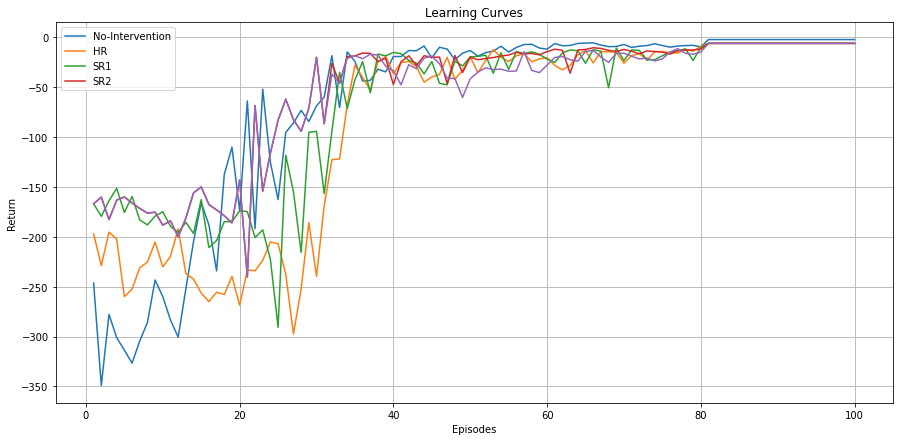

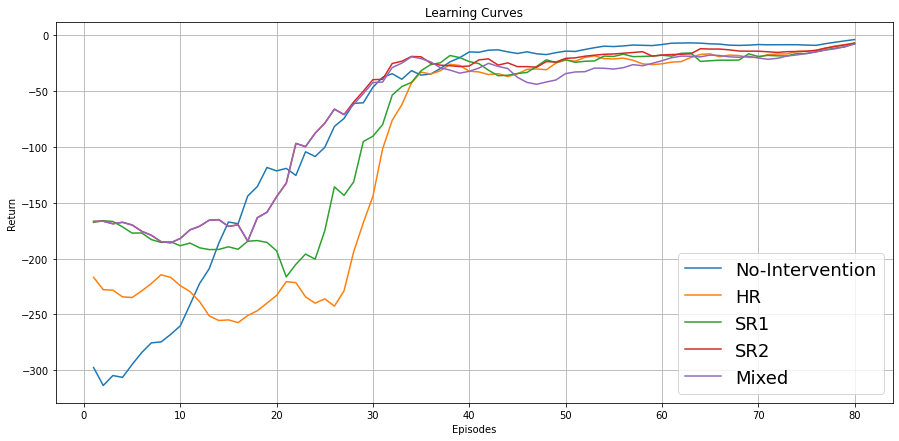

In [57]:
E = np.reshape(np.arange(1,N_Episodes+1),(1,N_Episodes))
fig = plt.figure(figsize=(15,7))
plt.plot(E.T,AveragedValues.T)
plt.plot(E.T,AvgReturn[0,:].T)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Learning Curves')
plt.legend(['No-Intervention','HR','SR1','SR2'])
plt.grid('minor')
plt.show()
V = np.copy(AveragedValues)
for i in range(4):
  V[i,:] = np.convolve(V[i,:],np.ones((1,5))[0]/5)[4::]
V2 = np.convolve(AvgReturn[0,:],np.ones((1,5))[0]/5)[4::]
fig = plt.figure(figsize=(15,7))
plt.plot(E.T[0:80],V[:,0:80].T)
plt.plot(E.T[0:80],V2[0:80].T)
plt.xlabel('Episodes')
plt.ylabel('Return')
plt.title('Learning Curves')
plt.legend(['No-Intervention','HR','SR1','SR2','Mixed'],fontsize=18)
plt.grid('minor')
plt.show()

Part IV: GP-UCB Example
---

0.0


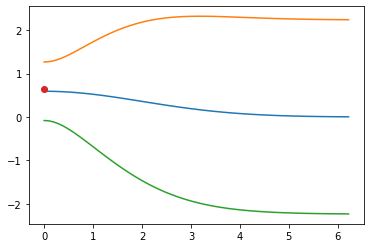

1.02


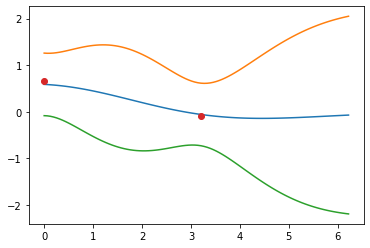

1.9800000000000002


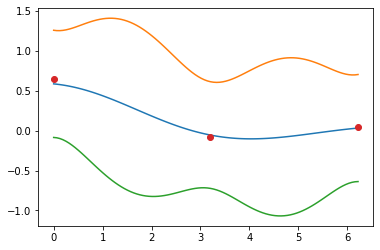

0.37999999999999995


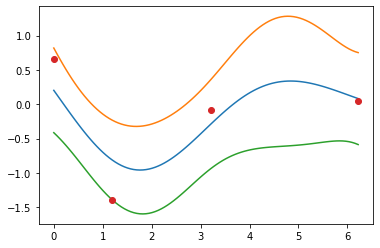

1.5199999999999998


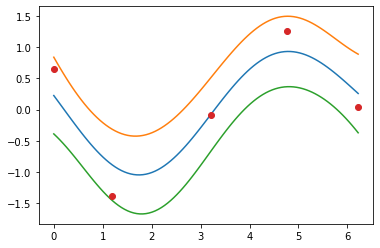

1.5199999999999998


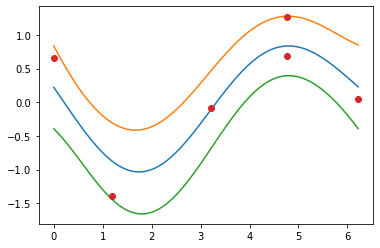

1.5199999999999998


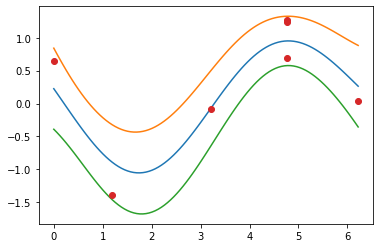

1.5199999999999998


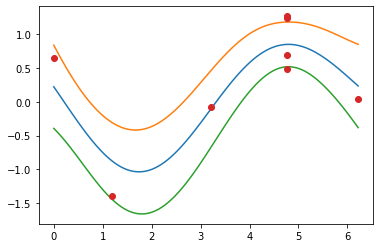

1.5199999999999998


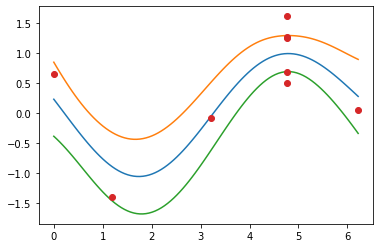

1.5199999999999998


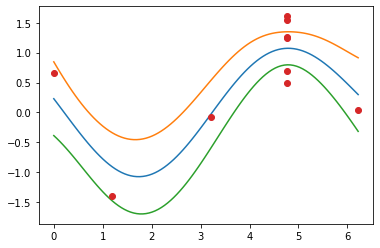

1.5199999999999998


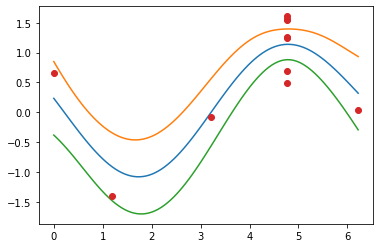

1.5199999999999998


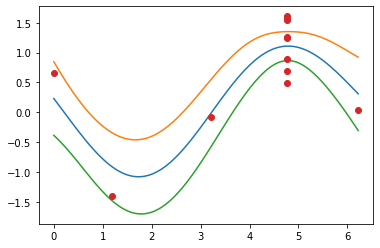

1.5199999999999998


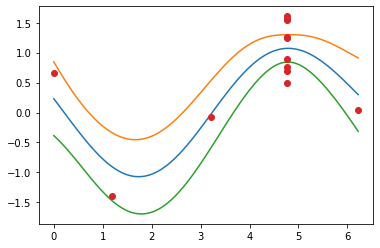

1.54


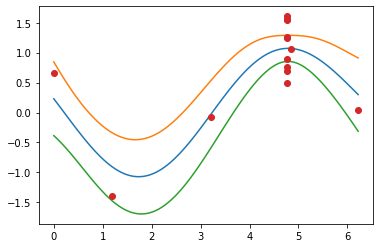

1.5199999999999998


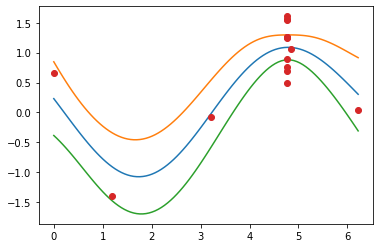

1.5199999999999998


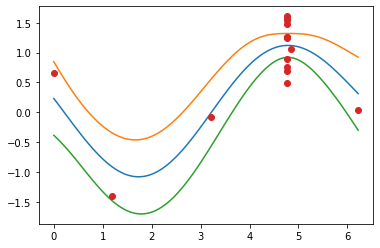

1.5199999999999998


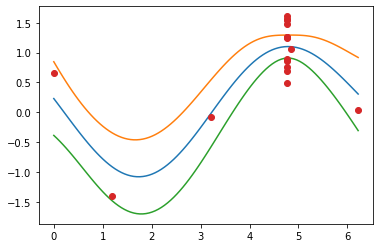

1.54


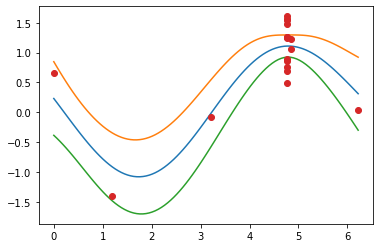

1.54


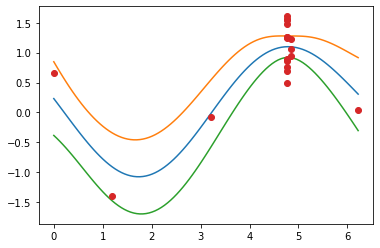

1.4800000000000002


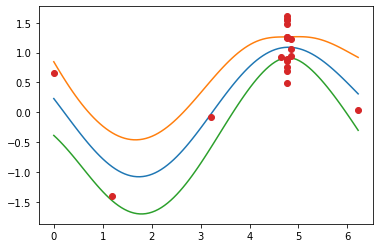

1.6


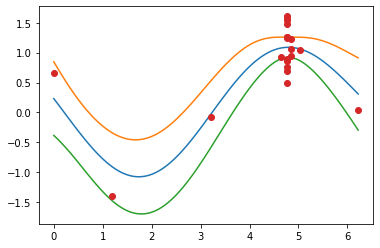

1.4800000000000002


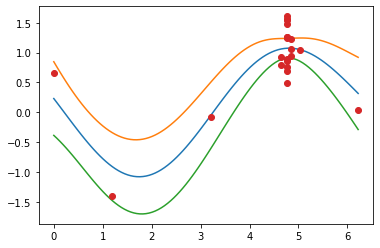

1.6


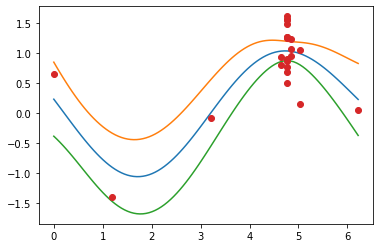

1.4200000000000002


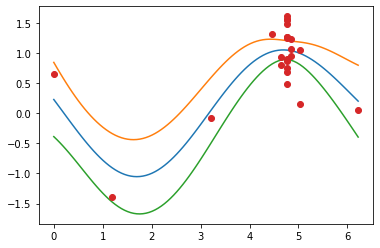

1.4200000000000002


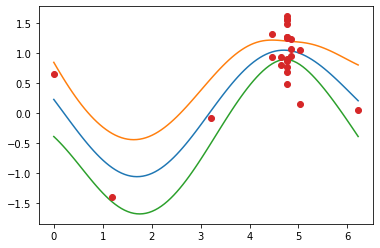

1.4200000000000002


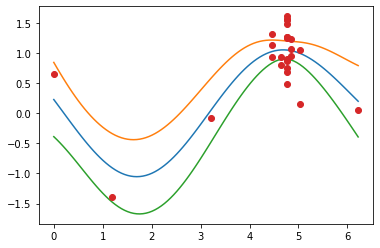

1.4200000000000002


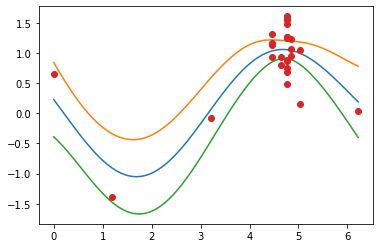

1.4200000000000002


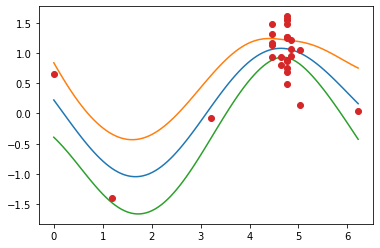

1.4


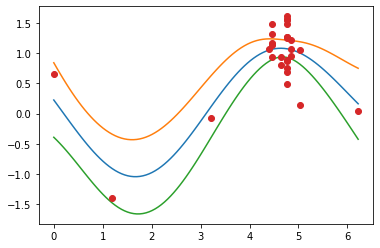

1.4


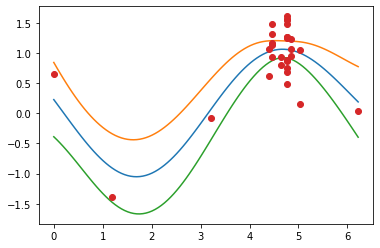

1.44


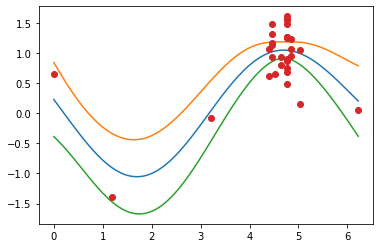

1.5199999999999998


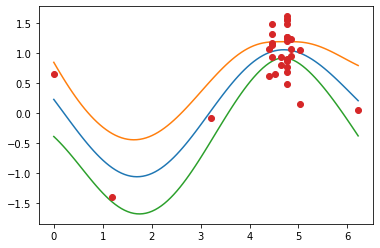

1.54


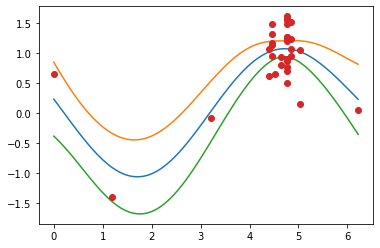

1.56


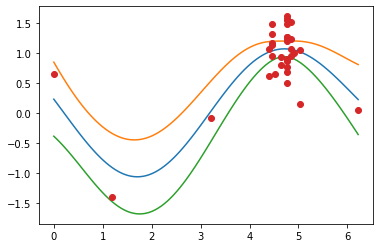

1.54


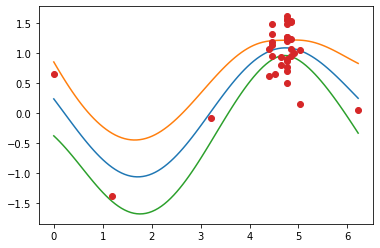

1.56


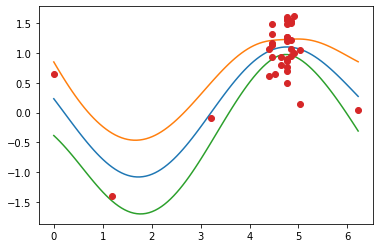

1.58


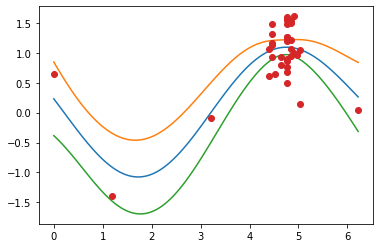

1.58


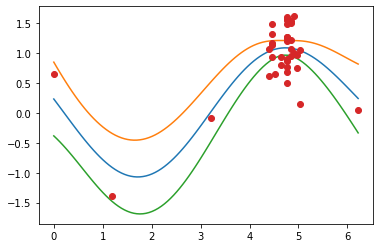

1.46


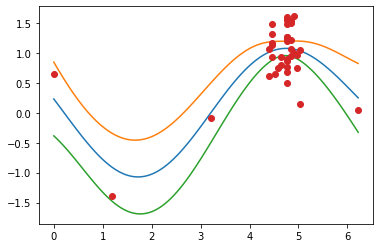

1.58


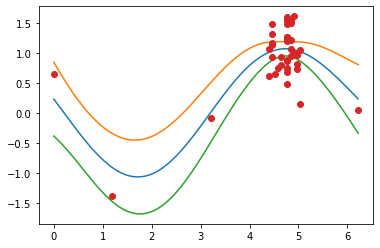

1.46


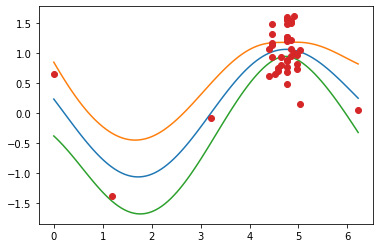

1.58


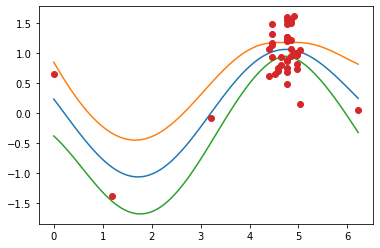

1.56


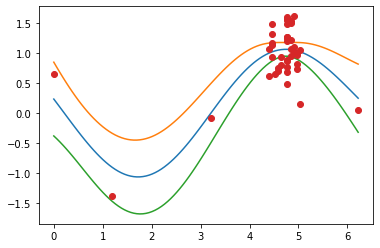

1.56


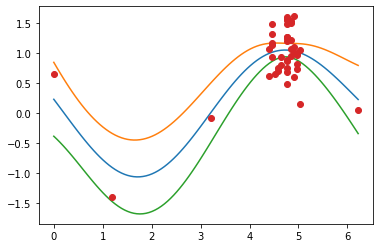

1.44


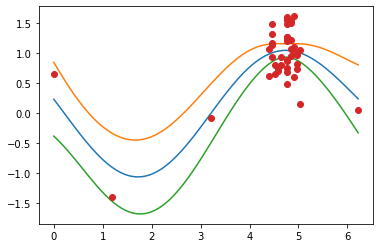

1.46


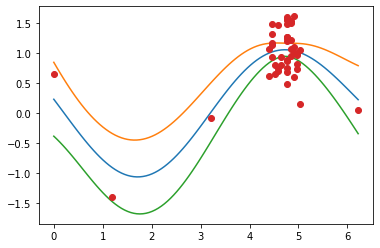

1.44


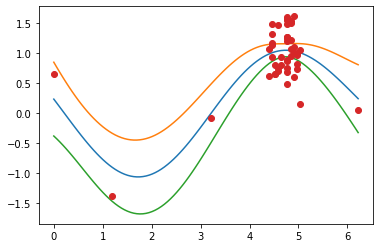

1.58


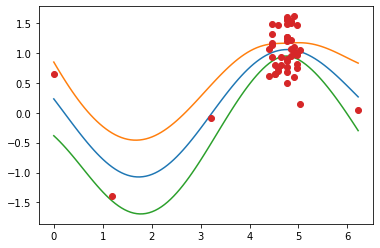

1.6


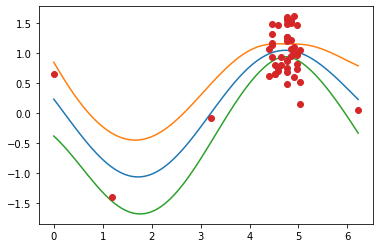

1.46


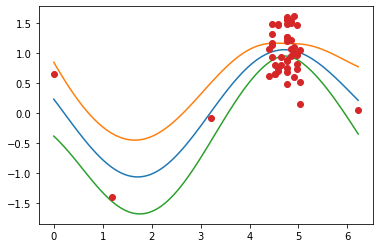

1.44


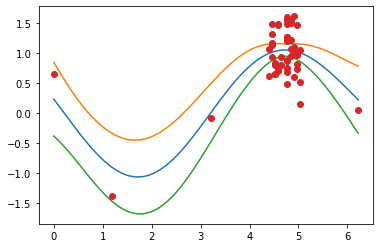

1.46


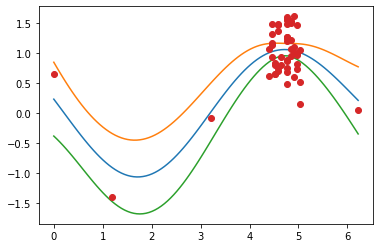

1.44


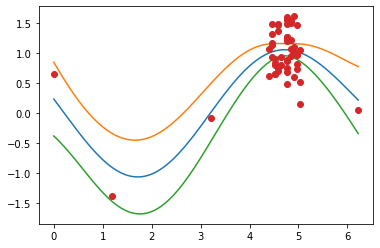

1.46


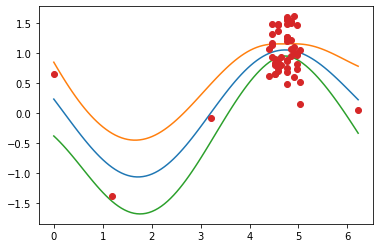

1.56


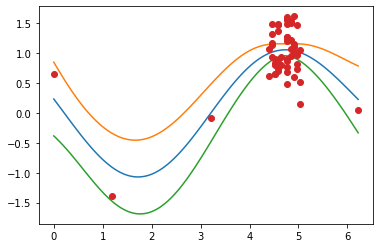

1.56


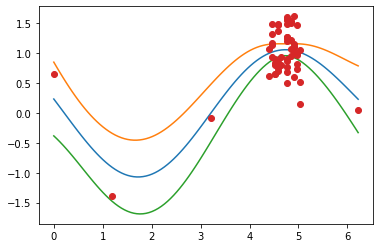

1.56


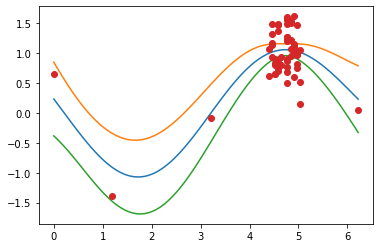

1.56


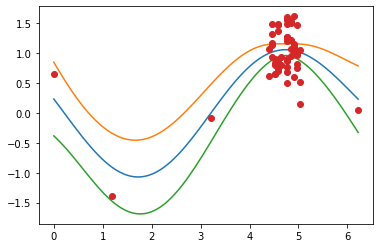

1.46


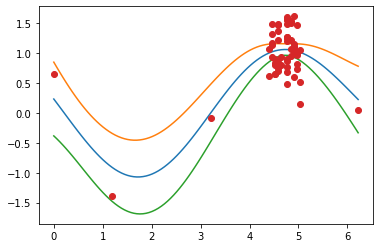

1.46


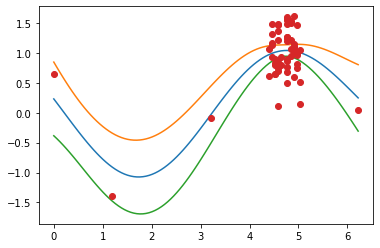

1.58


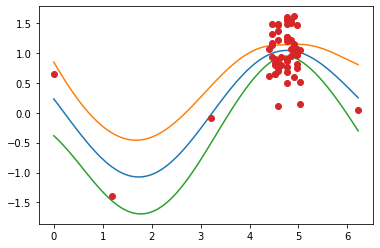

1.58


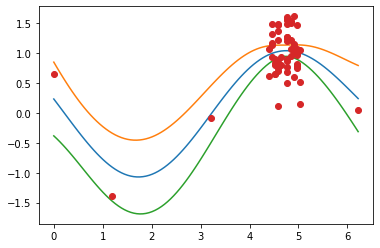

1.58


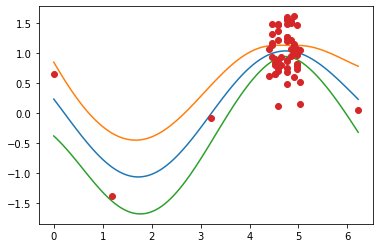

1.46


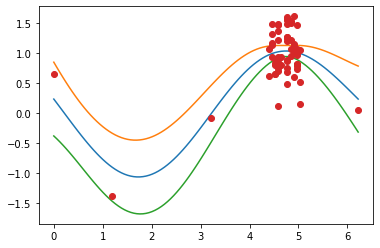

1.56


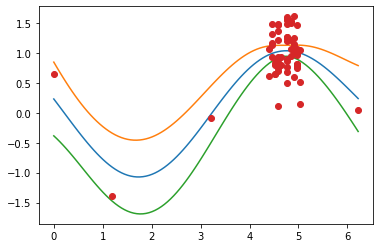

1.58


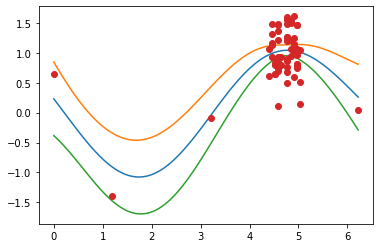

1.6


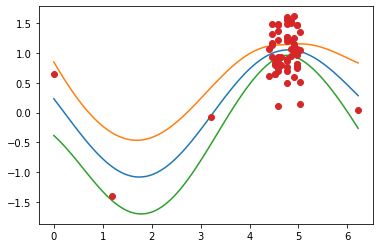

1.6


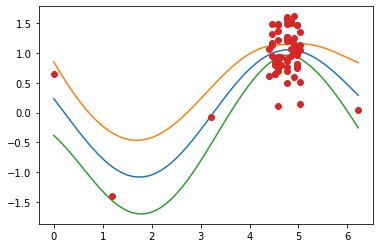

1.6


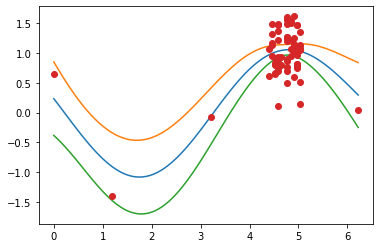

1.6


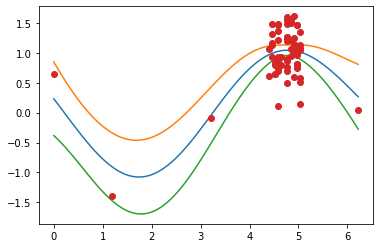

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def myfunc(x,var_n):
  y = -np.sin(x) + np.random.normal(0,np.sqrt(var_n))
  return y

def mykernel(x_vec,X_T):
  global N
  global l
  L = np.shape(x_T)[0]
  XT = np.reshape(x_T,(L,1))
  k_T = np.reshape(np.exp(-0.5*np.square(np.reshape(x_vec,(1,N))-XT)/(l**2)),(L,N))
  K_T = np.exp(-0.5*np.square(XT-XT.T)/(l**2))
  return k_T,K_T

def mykernel_all(x_vec):
  global N
  global l
  xv = np.reshape(x_vec,(1,N))
  K_T_all = np.exp(-0.5*np.square(xv-xv.T)/(l**2))
  return K_T_all

max_iter = 20
N = 100

var_n = 0.1
l = 2
mu_T = np.zeros((N,1))
s_T = np.zeros((N,1))
x_vec = np.arange(0,N)*2*np.pi/N
beta = 5

K_T_all = mykernel_all(x_vec)

for i in range(max_iter):
  # Choose greedily and Store
  x = x_vec[np.argmax(mu_T + np.sqrt(beta)*s_T)]
  y = myfunc(x,var_n)
  if i == 0:
    x_T = np.array([x])
    y_T = np.array([y])
  else:
    x_T = np.append(x_T,x)
    y_T = np.append(y_T,y)
  # Update
  k_T,K_T = mykernel(x_vec,x_T)
  temp = np.matmul((k_T.T),np.linalg.inv(K_T+var_n*np.identity(np.shape(K_T)[0])))
  kt = K_T_all - np.matmul(temp,k_T)
  mu_T = np.matmul(temp,np.reshape(y_T,(np.shape(y_T)[0],1)))
  s_T = np.reshape(np.sqrt(np.diag(kt)),(N,1))

  print(x/np.pi)
  plt.plot(x_vec,mu_T)
  plt.plot(x_vec,mu_T + np.sqrt(beta)*s_T)
  plt.plot(x_vec,mu_T - np.sqrt(beta)*s_T)
  plt.plot(x_T,y_T,'o')
  plt.show()

Part V: CISR (Optimization of Multiple CMDPs) (Failed)
---